Detection of Chemio-Physical Properties and Classification of Absorbing Aerosols with the SP2 via a Variational Autoencoder (VAE)

Prepared by Aaryan Doshi


---

This notebook denonstrates how laser induced incadesence signals from the Single Particle Soot Photometer (SP2) can be leveraged with a Variational Autoencdoer to aid in the classifciation of absorbing aerosols in the atmosphere

---



E-mail: aaryandoshi@gmail.com

Install pyroVED library:

In [ ]:
# Installation of a library that will be utilized when running the VAE
!pip install -q git+https://github.com/ziatdinovmax/pyroved.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 6.7 MB/s eta 0:00:00


In [4]:
import os
import math
import numpy as np
import seaborn as sns
import pandas as pd
import time
import random

import torch

from torch.nn import Conv1d, ConvTranspose1d
from torch.nn import Linear as Lin, ReLU, Sigmoid, ConstantPad1d
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
import pyroved as pv
import torch
import matplotlib.pyplot as plt

Importing of the Laboratory Samples

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_train.npy")
Y_train = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_train.npy")

X_val = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_val.npy")
Y_val = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_val.npy")

X_test = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_test.npy")
Y_test = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_test.npy")

In [ ]:
X_train.shape

(140082, 400, 4)

In [ ]:
Y_train.shape

(140082,)

Text(0.5, 1.0, 'Ch. 3')

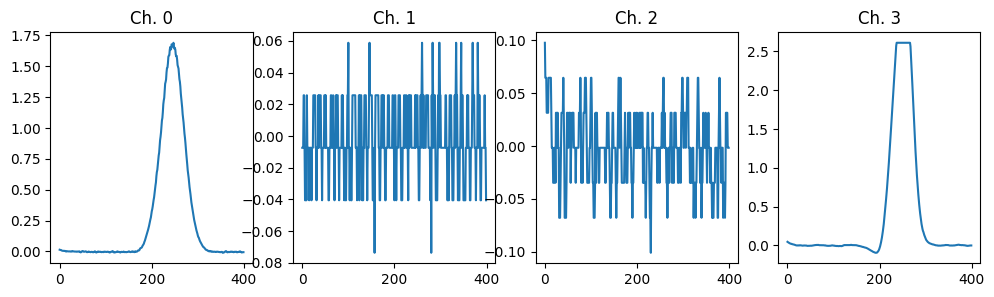

In [ ]:
n = random.randint(1, 140081)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
axes[0].plot(X_train[n,:,0])
axes[0].set_title("Ch. 0")
axes[1].plot(X_train[n,:,1])
axes[1].set_title("Ch. 1")
axes[2].plot(X_train[n,:,2])
axes[2].set_title("Ch. 2")
axes[3].plot(X_train[n,:,3])
axes[3].set_title("Ch. 3")

In [ ]:
# Saving Copy of the Original Signals before they have been Preprocessed
original_max_X_train = np.zeros((140082, 4))
for p_idx in range(140082):
  for c_idx in range(4):
    original_max_X_train[p_idx][c_idx] = np.max(X_train[p_idx, :, c_idx])

In [ ]:
channel_min_X_train = np.zeros((140082, 4))
channel_max_X_train = np.zeros((140082, 4))

# WOULD APPLY SAME LOGIC TO VALIDATION AND TEST DATASETS

for p_idx in range(140082):
  for c_idx in range(4):
    channel_min_X_train[p_idx][c_idx] = np.min(X_train[p_idx, :, c_idx])

  for c_idx in range(4):
    channel_max_X_train[p_idx][c_idx] = np.max(X_train[p_idx, :, c_idx])

print(channel_min_X_train[0])
print(channel_max_X_train[0])

for p_idx in range (0,140082):
  for c_idx in range(0, 4):
    s0 = (X_train[p_idx,:,c_idx] - channel_min_X_train[p_idx][c_idx])/(channel_max_X_train[p_idx][c_idx]- channel_min_X_train[p_idx][c_idx])
    X_train[p_idx,:,c_idx] = s0

[-0.00697026 -0.04301787 -0.11002647 -0.23763941]
[ 0.9186803  13.22634017 14.68150232  0.89371128]


In [ ]:
print(type(X_train))

<class 'numpy.ndarray'>


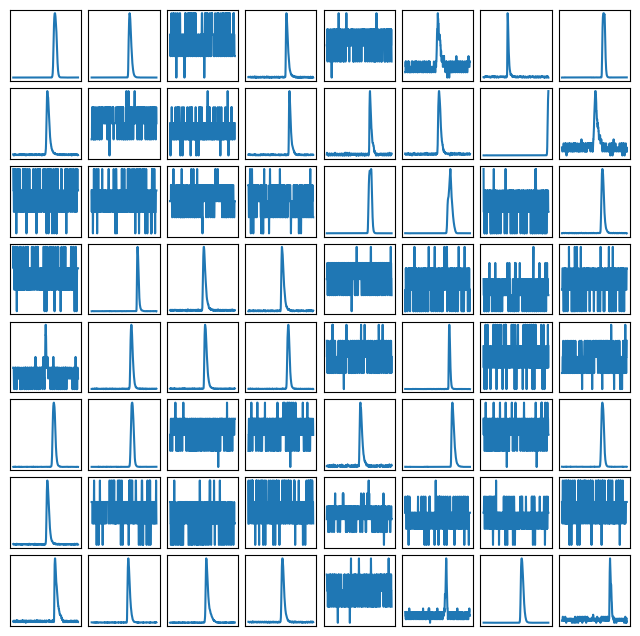

In [ ]:
X_train_C0 = torch.from_numpy(X_train[:,:, 1]).float()

#.unsqueeze(1) adds another channel
train_loader = pv.utils.init_dataloader(X_train_C0.unsqueeze(1), batch_size=64)

fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, (y,) in zip(axes.flat, train_loader):
    y_use = y.numpy()
    ax.plot(y_use[0, 0])

#A visualization of the SP2 signals after normalization and preprocessing

Applying the Variational Autoencdoer onto the Laser-Induced Incandesence Signals

In [ ]:
channel_one = (140081, )

# Initialize vanilla VAE
vae = pv.models.iVAE(data_dim = (400,), latent_dim = 3, invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(150):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 146.1990
Epoch: 2 Training loss: 139.6192
Epoch: 3 Training loss: 138.8030
Epoch: 4 Training loss: 138.4409
Epoch: 5 Training loss: 138.2559
Epoch: 6 Training loss: 138.1225
Epoch: 7 Training loss: 138.0242
Epoch: 8 Training loss: 137.9432
Epoch: 9 Training loss: 137.9002
Epoch: 10 Training loss: 137.8371
Epoch: 11 Training loss: 137.7930
Epoch: 12 Training loss: 137.7712
Epoch: 13 Training loss: 137.7333
Epoch: 14 Training loss: 137.7014
Epoch: 15 Training loss: 137.6716
Epoch: 16 Training loss: 137.6342
Epoch: 17 Training loss: 137.6285
Epoch: 18 Training loss: 137.6012
Epoch: 19 Training loss: 137.5857
Epoch: 20 Training loss: 137.5865
Epoch: 21 Training loss: 137.5675
Epoch: 22 Training loss: 137.5605
Epoch: 23 Training loss: 137.5322
Epoch: 24 Training loss: 137.5006
Epoch: 25 Training loss: 137.5167
Epoch: 26 Training loss: 137.5426
Epoch: 27 Training loss: 137.5077
Epoch: 28 Training loss: 137.4808
Epoch: 29 Training loss: 137.4863
Epoch: 30 Training loss

The training data encoded into the latent space

For better visualization every 50th sample was utilized instead

In [ ]:
every_50th_sample = X_train_C0[::50]
every_50th_sample.shape

every_50th_sample_y = Y_train[::50]
every_50th_sample_y.shape


(2802,)

In [ ]:
every_50th_sample.shape

torch.Size([2802, 400])

In [ ]:
every_50th_sample_y.shape

(2802,)

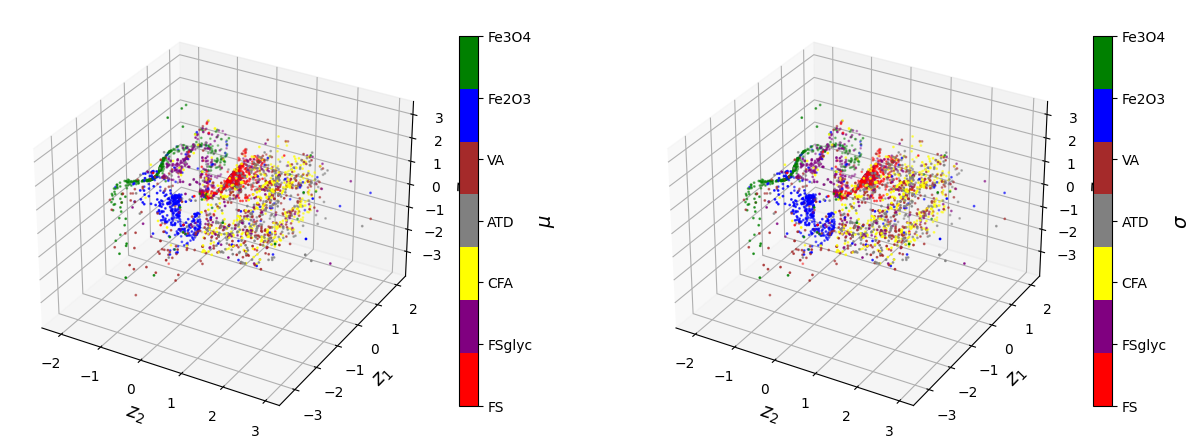

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

z_mean, z_sd = vae.encode(every_50th_sample)
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
target_names = ["FS", "FSglyc", "CFA", "ATD", "VA", "Fe2O3", "Fe3O4"]

# Scatter plot with discrete color bar for $\mu$
cmap1 = ListedColormap(['red', 'purple', 'yellow', 'gray', 'brown', 'blue', 'green'])  # Add more colors as needed
im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], zs=z_mean[:, -3], s=1, c=every_50th_sample_y, cmap=cmap1)
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
ax1.set_zlabel("$z_3$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, ticks=range(len(cmap1.colors)), shrink=.8)
cbar1.set_ticklabels(target_names)  # Add labels for each class
cbar1.set_label("$\mu$", fontsize=14)

# Scatter plot with discrete color bar for $\sigma$
cmap2 = ListedColormap(['red', 'purple', 'yellow', 'gray', 'brown', 'blue', 'green'])  # Add more colors as needed
im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], zs=z_mean[:, -3], s=1, c=every_50th_sample_y, cmap=cmap2)
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
ax2.set_zlabel("$z_3$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, ticks=range(len(cmap2.colors)), shrink=.8)
cbar2.set_ticklabels(target_names)  # Add labels for each class
cbar2.set_label("$\sigma$", fontsize=14)

plt.show()

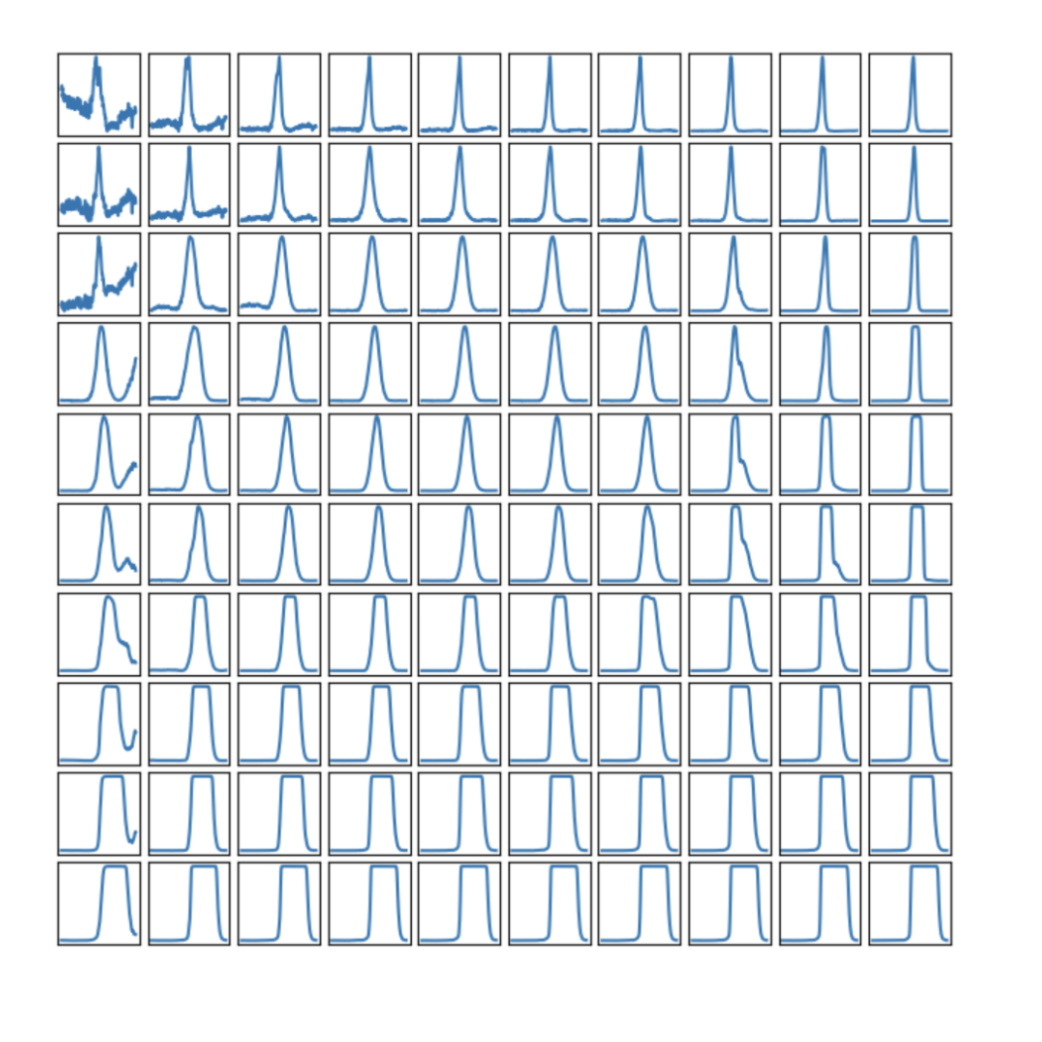

In [7]:
vae.manifold2d(d = 10)


Above, we see the learned latent manifold after training on the variational autencoder. Proper analysis of these results can give insights into the chemio-physical properties ---- such as peak height, incandescent intensity, and saturation of the signals

In [ ]:
channel_max_X_train.shape

(140082, 4)

In [ ]:
every_50th_sample_originalMax = original_max_X_train[::50]
every_50th_sample_originalMax.shape

(2802, 4)

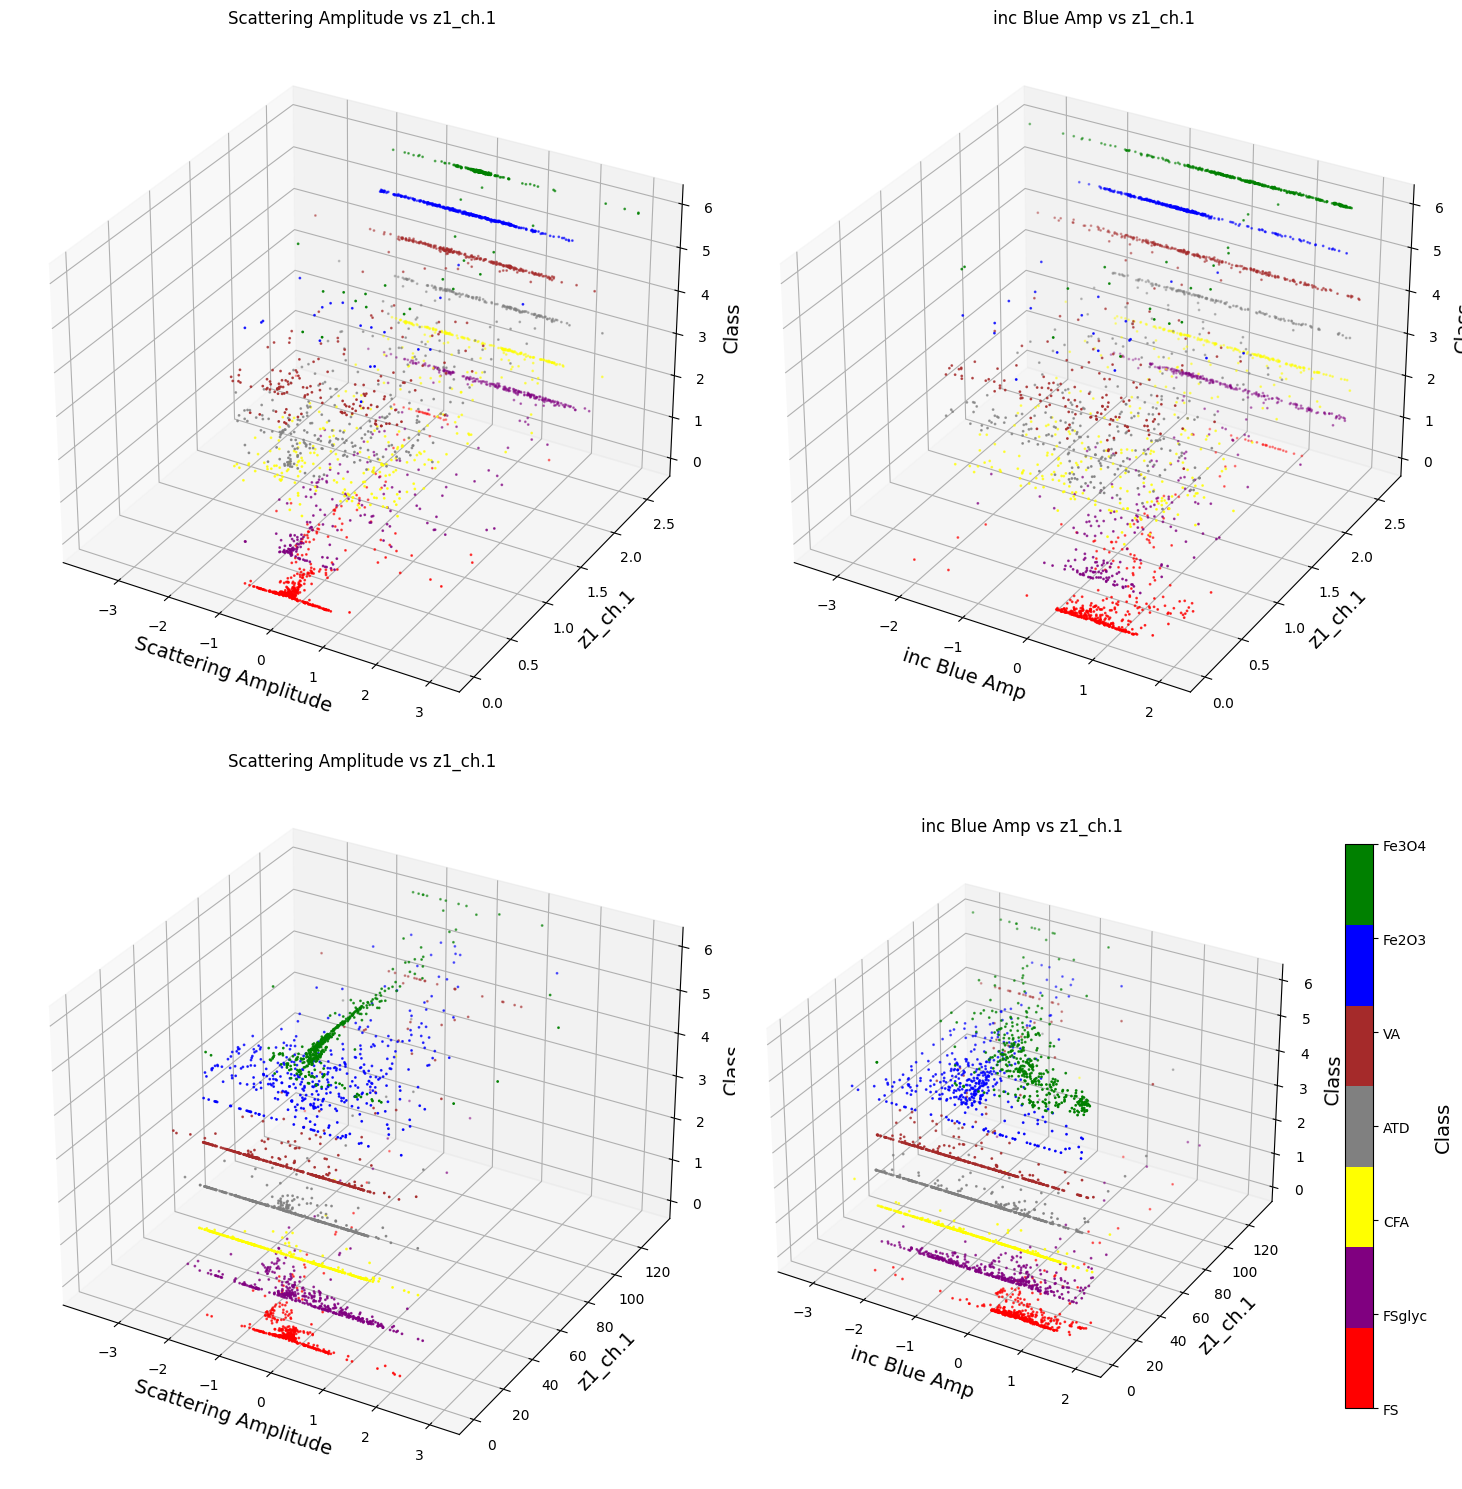

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

target_names = ["FS", "FSglyc", "CFA", "ATD", "VA", "Fe2O3", "Fe3O4"]
cmap1 = ListedColormap(['red', 'purple', 'yellow', 'gray', 'brown', 'blue', 'green'])

fig = plt.figure(figsize=(15, 15))
ax = fig.subplots(2, 2, subplot_kw={'projection': '3d'})

# Scatter plot with 3D axes for the first subplot
scatter1 = ax[0, 0].scatter(z_mean[:, 0], every_50th_sample_originalMax[:, 0], zs=every_50th_sample_y, c=every_50th_sample_y, cmap=cmap1, s=1)
ax[0, 0].set_xlabel("Scattering Amplitude", fontsize=14)
ax[0, 0].set_ylabel("z1_ch.1", fontsize=14)
ax[0, 0].set_zlabel("Class", fontsize=14)
ax[0, 0].set_title("Scattering Amplitude vs z1_ch.1")

# Scatter plot with 3D axes for the second subplot
scatter2 = ax[0, 1].scatter(z_mean[:, 1], every_50th_sample_originalMax[:, 0], zs=every_50th_sample_y, c=every_50th_sample_y, cmap=cmap1, s=1)
ax[0, 1].set_xlabel("inc Blue Amp", fontsize=14)
ax[0, 1].set_ylabel("z1_ch.1", fontsize=14)
ax[0, 1].set_zlabel("Class", fontsize=14)
ax[0, 1].set_title("inc Blue Amp vs z1_ch.1")

# Scatter plot with 3D axes for the third subplot
scatter3 = ax[1, 0].scatter(z_mean[:, 0], every_50th_sample_originalMax[:, 1], zs=every_50th_sample_y, c=every_50th_sample_y, cmap=cmap1, s=1)
ax[1, 0].set_xlabel("Scattering Amplitude", fontsize=14)9
ax[1, 0].set_ylabel("z1_ch.1", fontsize=14)
ax[1, 0].set_zlabel("Class", fontsize=14)
ax[1, 0].set_title("Scattering Amplitude vs z1_ch.1")

# Scatter plot with 3D axes for the fourth subplot
scatter4 = ax[1, 1].scatter(z_mean[:, 1], every_50th_sample_originalMax[:, 1], zs=every_50th_sample_y, c=every_50th_sample_y, cmap=cmap1, s=1)
ax[1, 1].set_xlabel("inc Blue Amp", fontsize=14)
ax[1, 1].set_ylabel("z1_ch.1", fontsize=14)
ax[1, 1].set_zlabel("Class", fontsize=14)
ax[1, 1].set_title("inc Blue Amp vs z1_ch.1")

# Add a color bar to the last subplot
cbar = fig.colorbar(scatter4, ax=ax[1, 1], ticks=range(len(cmap1.colors)), shrink=0.8)
cbar.set_ticklabels(target_names)  # Add labels for each class
cbar.set_label("Class", fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
every_50th_sample_y

array([0., 0., 0., ..., 6., 6., 6.])

In [ ]:


#smooth kernel density with marginal histograms (https://seaborn.pydata.org/examples/smooth_bivariate_kde.html)
# use this to see the concentration of points in the latent representation


from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Assuming z_mean is your latent space representation
# and every_50th_sample_y are your true labels

# Number of clusters should match the number of unique labels
# maybe chane this to higher number of clusters instead
n_clusters = 7

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
predicted_labels = kmeans.fit_predict(z_mean)

# Calculate metrics
ari_score = adjusted_rand_score(every_50th_sample_y, predicted_labels)
nmi_score = normalized_mutual_info_score(every_50th_sample_y, predicted_labels)

print(f"Adjusted Rand Index: {ari_score}")
print(f"Normalized Mutual Information: {nmi_score}")

#coloring the latent space for k-means


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index: 0.06366449044233001
Normalized Mutual Information: 0.2822597038497399


# The qualitiative results received from this experiment shed light on the chemio-physical properties of aerosols, which can have an insturmental impact on climate change. From the latent manifold, we were able to gain insights into the saturation, peak hight, incandescent intensity and symmetry of signals